In [ ]:
# Libraries

# Related to audio processing
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft
import librosa as lb
from scipy import signal
import soundfile as sf
from scipy.signal.windows import hamming

# Related to classification
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

On the function below, read_audio, we will do:
  * Loading the audio files from the folder
  * .wav conversion using librosa.load
  * normalization
  * using fixed sampling rate for each audio

In [ ]:
def read_audio(sr=16000):
    '''
    Reads audio files, assigns labels, and returns data and labels.

    :param sr: Sampling rate, so each audio file is in the same format.
    :return np.array(shuffled_audios), np.array(shuffled_labels): Shuffled audio waveforms and their labels.
    '''

    # audios collected:
    tram_audios_group = []
    car_audios_group = []
    labels_group = []

    # audios collected by others:
    tram_audios_other = []
    car_audios_other = []
    labels_other = []

    dataset_size = 125 
    begin_index = 101 

    path = 'dataset/'  # Adjust your path as needed

    # loop over the audios collected ---
    for i in range(begin_index, dataset_size+1):
        # Load tram audio
        tram_audio, _ = lb.load(path + 'tram/tram' + str(i) + '.wav', sr=sr)
        tram_audio = tram_audio / np.max(np.abs(tram_audio)) # normalization
        tram_audios_group.append(tram_audio)
        labels_group.append(0) # Label: 0 for tram

        # Load car audio
        car_audio, _ = lb.load(path + 'car/car' + str(i) + '.wav', sr=sr)
        car_audio = car_audio / np.max(np.abs(car_audio)) # normalization
        car_audios_group.append(car_audio)
        labels_group.append(1) # Label: 1 for car

    # loop over the audios collected by others ---
    for i in range(1, begin_index):
        # Load tram audio
        tram_audio, _ = lb.load(path + 'tram/tram' + str(i) + '.wav', sr=sr)
        tram_audio = tram_audio / np.max(np.abs(tram_audio)) # normalization
        tram_audios_other.append(tram_audio)
        labels_other.append(0) # Label: 0 for tram

        # Load car audio
        car_audio, _ = lb.load(path + 'car/car' + str(i) + '.wav', sr=sr)
        car_audio = car_audio / np.max(np.abs(car_audio)) # normalization
        car_audios_other.append(car_audio)
        labels_other.append(1) # Label: 1 for car

    # Combine data and labels from our group and other groups
    all_audios_group = tram_audios_group + car_audios_group
    all_labels_group = labels_group

    all_audios_other = tram_audios_other + car_audios_other
    all_labels_other = labels_other

    np.random.seed(4) # So we get same shuffled file everytime
    # Shuffle the data and labels together (used zip)
    combined_group = list(zip(all_audios_group, all_labels_group))
    np.random.shuffle(combined_group)
    shuffled_audios_group, shuffled_labels_group = zip(*combined_group)

    combined_other = list(zip(all_audios_other, all_labels_other))
    np.random.shuffle(combined_other)
    shuffled_audios_other, shuffled_labels_other = zip(*combined_other)

    return np.array(shuffled_audios_group, dtype=object), np.array(shuffled_labels_group), np.array(shuffled_audios_other, dtype=object), np.array(shuffled_labels_other)
    # I specify dtype=object since each audio has different dimensions for now, eg one can have 13516, in later stages it will be trimmed

audios_group, labels_group, audios_other, labels_other = read_audio(sr=16000)

# Example usage
print(f"Successfully Loaded {len(audios_group) + len(audios_other)} audio waveforms and labels.")
#print(f"Labels: {labels_other[:10]}")  # Display first 10 labels
#print(len(audios_group[10]), len(audios_other[97])) # checking size of each audio
#print(audios_other[0][3000:3010])

Successfully Loaded 250 audio waveforms and labels.


Below, I trim all audio files to the same length to ensure consistent dimensions during feature extraction.

In [ ]:
def trim_waveforms(audios, duration=5, sr=16000):
    '''
    Trims audio waveforms to a fixed duration. Some might be less than 5 seconds (add padding in that case) but I've manually checked it is at least 5 sec.s long

    :param audios: List of audio waveforms.
    :param duration: Duration to which the audio waveforms are trimmed.
    :param sr: Sampling rate, so each audio file is in the same format.
    :return: Numpy array of trimmed audio waveforms.
    '''
    trimmed_audios = []

    for audio in audios:
        # Trim audio waveform
        trimmed_audio = np.array(audio[:duration * sr], dtype=np.float32)
        trimmed_audios.append(trimmed_audio)

    return np.array(trimmed_audios)

audios_group_trimmed = trim_waveforms(audios_group, sr=16000)
audios_other_trimmed = trim_waveforms(audios_other, sr=16000)
print(audios_group_trimmed.shape, audios_other_trimmed.shape)
#plt.plot(audios_group_trimmed[0])

(50, 80000) (200, 80000)


# Features extraction

In [ ]:
def extract_stft_spec(audios, sr=16000, win_length=1024, hop_length=256):
    '''
    Extracts short-time Fourier transform spectrogram from audio waveforms.

    :param audios: List of audio waveforms.
    :param sr: Sampling rate.
    :param win_length: Number of samples per frame.
    :param hop_length: Number of samples between frames.
    :return: List of extracted STFT spectrograms.
    '''
    stft_specs = []
    stft_specs_db = []

    for audio in audios:
        # Extracting STFT spectrogram
        stft_spec = np.abs(lb.stft(audio, n_fft=win_length, hop_length=hop_length))
        stft_spec_db = lb.amplitude_to_db(stft_spec, ref=np.max)
        stft_specs.append(stft_spec)
        stft_specs_db.append(stft_spec_db)

    return np.array(stft_specs, dtype=np.float32), np.array(stft_specs_db, dtype=np.float32)

stft_specs_group, stft_specs_db_group = extract_stft_spec(audios_group_trimmed, sr=16000)
stft_specs_other, stft_specs_db_other = extract_stft_spec(audios_other_trimmed, sr=16000)
print(stft_specs_group.shape, stft_specs_other.shape)

(50, 513, 313) (200, 513, 313)


In [ ]:
def extract_mel_spectrogram(audios, sr=16000, n_mels=128, win_length=1024, hop_length=256):
    '''
    Extracts mel spectrogram from audio waveforms.

    :param audios: List of audio waveforms.
    :param sr: Sampling rate.
    :param n_mels: Number of mel bands to generate.
    :param win_length: Number of samples per frame.
    :param hop_length: Number of samples between frames.
    :return: List of extracted mel spectrograms.
    '''
    mel_spectrograms = []

    for audio in audios:
        # Extracting mel spectrogram
        mel_spectrogram = lb.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels, n_fft=win_length, hop_length=hop_length)
        mel_spectrograms.append(mel_spectrogram)

    return np.array(mel_spectrograms, dtype=np.float32)

mel_spectrograms_group = extract_mel_spectrogram(audios_group_trimmed, sr=16000)
mel_spectrograms_other = extract_mel_spectrogram(audios_other_trimmed, sr=16000)
print(mel_spectrograms_group.shape, mel_spectrograms_other.shape)

(50, 128, 313) (200, 128, 313)


In [ ]:
def extract_mfcc_features(audios, sr=16000, n_mfcc=13, win_length=1024, hop_length=256):
    '''
    Extracts mfcc features from audio waveforms.

    :param audios: List of audio waveforms.
    :param sr: Sampling rate.
    :param n_mfcc: Number of MFCC coefficients to extract.
    :param win_length: Number of samples per frame.
    :param hop_length: Number of samples between frames.
    :return: List of extracted features and their mean values.
    '''
    features = []

    for audio in audios:
        # Extracting MFCC features
        mfcc = lb.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, n_fft=win_length, hop_length=hop_length)
        features.append(mfcc)

    return np.array(features, dtype=np.float32)

mfcc_features_group = extract_mfcc_features(audios_group_trimmed, sr=16000)
mfcc_features_other = extract_mfcc_features(audios_other_trimmed, sr=16000)
print(mfcc_features_group.shape, mfcc_features_other.shape)

(50, 13, 313) (200, 13, 313)


In [ ]:
# Additionally
def extract_cqt_spec(audios, sr=16000, n_bins=84, hop_length=256):
    '''
    Extracts constant-Q transform spectrogram from audio waveforms.

    :param audios: List of audio waveforms.
    :param sr: Sampling rate.
    :param n_bins: Number of frequency bins.
    :param hop_length: Number of samples between frames.
    :return: List of extracted CQT spectrograms.
    '''
    cqt_specs = []

    for audio in audios:
        # Extracting CQT spectrogram
        cqt_spec = np.abs(lb.cqt(audio, sr=sr, n_bins=n_bins, hop_length=hop_length))
        cqt_specs.append(cqt_spec)

    return np.array(cqt_specs, dtype=np.float32)

cqt_specs_group = extract_cqt_spec(audios_group_trimmed, sr=16000)
cqt_specs_other = extract_cqt_spec(audios_other_trimmed, sr=16000)
print(cqt_specs_group.shape, cqt_specs_other.shape)

(50, 84, 313) (200, 84, 313)


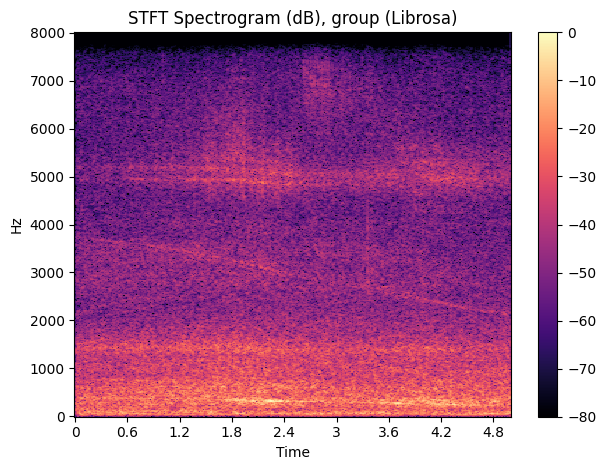

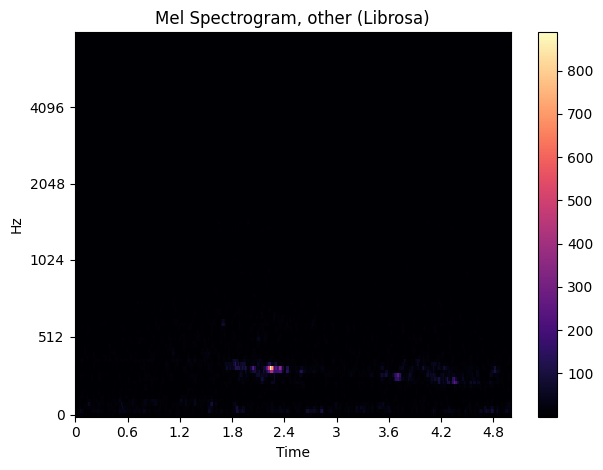

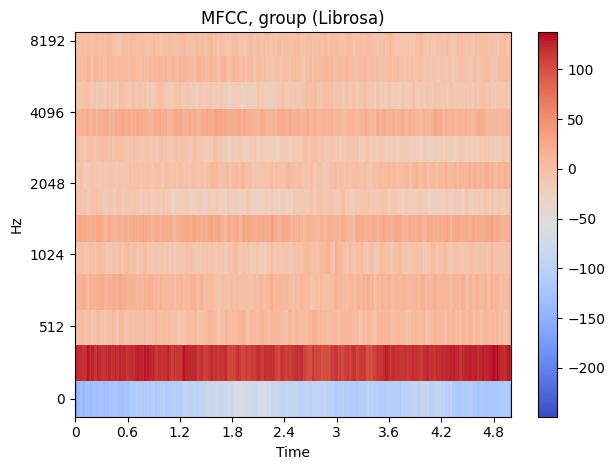

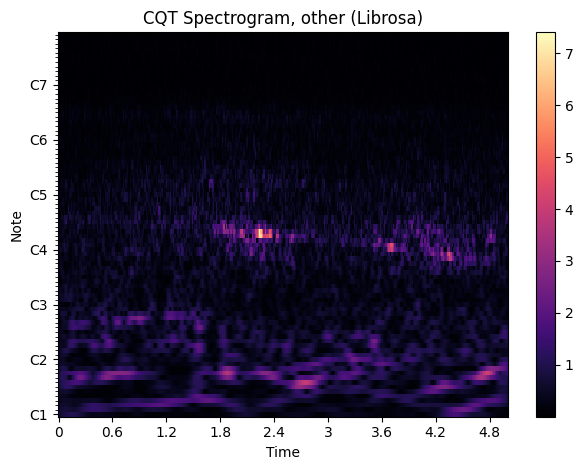

In [ ]:
def show_sample_features(features, feature_type='MFCC', ylabel='hz', sr=16000, hop_length=256):
    '''
    Displays sample features.

    :param features: List of features.
    :param feature_type: Type of feature.
    '''
    sample_feature = features[0]
    lb.display.specshow(sample_feature,
                        sr=sr,
                        hop_length=hop_length,
                        x_axis='time',
                        y_axis=ylabel)
    plt.colorbar()
    plt.title(f'{feature_type} (Librosa)')
    plt.tight_layout()
    plt.show()

show_sample_features(stft_specs_db_group, feature_type='STFT Spectrogram (dB), group', ylabel='hz')
#show_sample_features(stft_specs_db_other, feature_type='STFT Spectrogram (dB), other', ylabel='hz')

#show_sample_features(mel_spectrograms_group, feature_type='Mel Spectrogram, group', ylabel='mel')
show_sample_features(mel_spectrograms_other, feature_type='Mel Spectrogram, other', ylabel='mel')

show_sample_features(mfcc_features_group, feature_type='MFCC, group', ylabel='mel')
#show_sample_features(mfcc_features_other, feature_type='MFCC, other', ylabel='mel')

#show_sample_features(cqt_specs_group, feature_type='CQT Spectrogram, group', ylabel='cqt_note')
show_sample_features(cqt_specs_other, feature_type='CQT Spectrogram, other', ylabel='cqt_note')

<font size=5 color="yellow">**Model 1: KNN**</font>

Problem: the data is in the form of 2D arrays (features), but KNN requires 1D arrays.

Option 1: Flattening the feature matrices.

Option 2: Max-pooling the feature matrices to reduce their dimensions over time

Option 3: Average-pooling over time axis

In [ ]:
def knn_analysis(specs_other, labels_other, specs_group, labels_group, squeeze_type):
  """
    Accepts the features and labels and returns best knn model's test results
  """
  X_train_2D, X_val_2D, y_train, y_val = train_test_split(specs_other, labels_other, test_size=0.2, random_state=42) # 80% training, 20% validation
  X_test_2D, y_test = specs_group, labels_group

  #Squeeze types
  if squeeze_type == "flat":
      X_train, X_val, X_test = X_train_2D.reshape(X_train_2D.shape[0], -1), X_val_2D.reshape(X_val_2D.shape[0], -1), X_test_2D.reshape(X_test_2D.shape[0], -1)
  elif squeeze_type == "avg":
      X_train, X_val, X_test = np.mean(X_train_2D, axis=2), np.mean(X_val_2D, axis=2), np.mean(X_test_2D, axis=2)
  elif squeeze_type == "max":
      X_train, X_val, X_test = np.max(X_train_2D, axis=2), np.max(X_val_2D, axis=2), np.max(X_test_2D, axis=2)
  knn_model = KNeighborsClassifier()

  # Hyperparameter tuning with GridSearchCV (Picks the best performing neighbor_size)
  param_grid = {'n_neighbors': [3, 5, 7, 9, 11]}
  # To pick the best model we take all the below scores into consideration:
  scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision_macro',
    'recall': 'recall_macro',
    'f1': 'f1_macro'
  }
  grid_search = GridSearchCV(
      knn_model,
      param_grid,
      cv=5,
      scoring=scoring,
      refit='accuracy',
      n_jobs=-1,
      return_train_score=True)

  grid_search.fit(X_train, y_train)

  """WE DON'T HANDLE PICKING THE BEST NEIGHBOR, GRIDSEARCHCV HANDLES IT"""

  # Best model
  best_knn_model = grid_search.best_estimator_
  best_n_neighbors = grid_search.best_params_['n_neighbors']

  # Train
  best_knn_model.fit(X_train, y_train)

  # Validation scores (Just for formality since GridSearch will implicitly handle the validation process)
  y_val_pred = best_knn_model.predict(X_val)

  precision = precision_score(y_val, y_val_pred)
  recall = recall_score(y_val, y_val_pred)
  f1 = f1_score(y_val, y_val_pred)

  """WE WON'T PRINT ANY OUTCOME FROM TRAINING AND VALIDATION"""
  # Test data scores
  y_test_pred = best_knn_model.predict(X_test)
  test_accuracy = accuracy_score(y_test, y_test_pred)
  test_precision = precision_score(y_test, y_test_pred)
  test_recall = recall_score(y_test, y_test_pred)
  test_f1 = f1_score(y_test, y_test_pred)

  print(f"Best neighbor size: {best_n_neighbors}")
  print(f"Test accuracy: {test_accuracy}")
  print(f"Test precision: {test_precision}")
  print(f"Test recall: {test_recall}")
  print(f"Test f1_score: {test_f1}")

In [ ]:
knn_analysis(mfcc_features_other, labels_other, mfcc_features_group, labels_group, squeeze_type="avg")
print("============================================================")
knn_analysis(mfcc_features_other, labels_other, mfcc_features_group, labels_group, squeeze_type="max")
print("============================================================")
knn_analysis(mfcc_features_other, labels_other, mfcc_features_group, labels_group, squeeze_type="flat")
print("============================================================")
knn_analysis(mel_spectrograms_other, labels_other, mel_spectrograms_group, labels_group, squeeze_type="avg")
print("============================================================")
knn_analysis(mel_spectrograms_other, labels_other, mel_spectrograms_group, labels_group, squeeze_type="max")
print("============================================================")
knn_analysis(mel_spectrograms_other, labels_other, mel_spectrograms_group, labels_group, squeeze_type="flat")
print("============================================================")
knn_analysis(stft_specs_db_other, labels_other, stft_specs_db_group, labels_group, squeeze_type="avg")
print("============================================================")
knn_analysis(stft_specs_db_other, labels_other, stft_specs_db_group, labels_group, squeeze_type="max")
print("============================================================")
knn_analysis(stft_specs_db_other, labels_other, stft_specs_db_group, labels_group, squeeze_type="flat")
print("============================================================")
knn_analysis(cqt_specs_other, labels_other, cqt_specs_group, labels_group, squeeze_type="avg")
print("============================================================")
knn_analysis(cqt_specs_other, labels_other, cqt_specs_group, labels_group, squeeze_type="max")
print("============================================================")
knn_analysis(cqt_specs_other, labels_other, cqt_specs_group, labels_group, squeeze_type="flat")
print("============================================================")

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Best neighbor size: 5
Test accuracy: 0.5
Test precision: 0.0
Test recall: 0.0
Test f1_score: 0.0
Best neighbor size: 3
Test accuracy: 0.52
Test precision: 0.52
Test recall: 0.52
Test f1_score: 0.52
Best neighbor size: 3
Test accuracy: 0.52
Test precision: 0.52
Test recall: 0.52
Test f1_score: 0.52
Best neighbor size: 3
Test accuracy: 0.52
Test precision: 0.52
Test recall: 0.52
Test f1_score: 0.52
Best neighbor size: 3
Test accuracy: 0.52
Test precision: 0.52
Test recall: 0.52
Test f1_score: 0.52
Best neighbor size: 3
Test accuracy: 0.52
Test precision: 0.52
Test recall: 0.52
Test f1_score: 0.52
Best neighbor size: 3
Test accuracy: 0.52
Test precision: 0.52
Test recall: 0.52
Test f1_score: 0.52
Best neighbor size: 3
Test accuracy: 0.52
Test precision: 0.52
Test recall: 0.52
Test f1_score: 0.52
Best neighbor size: 3
Test accuracy: 0.52
Test precision: 0.52
Test recall: 0.52
Test f1_score: 0.52
Best neighbor size: 3
Test accuracy: 0.52
Test precision: 0.52
Test recall: 0.52
Test f1_score:

<font size=5 color="yellow">**Model 2: Logistic Regression**</font>

Problem: the data is in the form of 2D arrays (features), but Log_reg requires 1D arrays.

Option 1: Flattening the feature matrices.

Option 2: Max-pooling the feature matrices to reduce their dimensions over time

Option 3: Average-pooling over time axis

In [ ]:
def log_reg_analysis(specs_other, labels_other, specs_group, labels_group, squeeze_type):
  """
    Accepts the features and labels and returns scores of logistic regression model
  """
  X_train_2D, X_val_2D, y_train, y_val = train_test_split(specs_other, labels_other, test_size=0.2, random_state=42) # 80% training, 20% validation
  X_test_2D, y_test = specs_group, labels_group

  #Squeeze types
  if squeeze_type == "flat":
      X_train, X_val, X_test = X_train_2D.reshape(X_train_2D.shape[0], -1), X_val_2D.reshape(X_val_2D.shape[0], -1), X_test_2D.reshape(X_test_2D.shape[0], -1)
  elif squeeze_type == "avg":
      X_train, X_val, X_test = np.mean(X_train_2D, axis=2), np.mean(X_val_2D, axis=2), np.mean(X_test_2D, axis=2)
  elif squeeze_type == "max":
      X_train, X_val, X_test = np.max(X_train_2D, axis=2), np.max(X_val_2D, axis=2), np.max(X_test_2D, axis=2)

  # Model
  log_reg_model = LogisticRegression(max_iter=100000)

  # Train
  log_reg_model.fit(X_train, y_train)

  # Validation scores
  y_val_pred = log_reg_model.predict(X_val)

  precision = precision_score(y_val, y_val_pred)
  recall = recall_score(y_val, y_val_pred)
  f1 = f1_score(y_val, y_val_pred)

  # Test data scores
  y_test_pred = log_reg_model.predict(X_test)
  test_accuracy = accuracy_score(y_test, y_test_pred)
  test_precision = precision_score(y_test, y_test_pred)
  test_recall = recall_score(y_test, y_test_pred)
  test_f1 = f1_score(y_test, y_test_pred)

  print(f"Test accuracy: {test_accuracy}")
  print(f"Test precision: {test_precision}")
  print(f"Test recall: {test_recall}")
  print(f"Test f1_score: {test_f1}")

In [ ]:
log_reg_analysis(mfcc_features_other, labels_other, mfcc_features_group, labels_group, squeeze_type="avg")
print("============================================================")
log_reg_analysis(mfcc_features_other, labels_other, mfcc_features_group, labels_group, squeeze_type="max")
print("============================================================")
log_reg_analysis(mfcc_features_other, labels_other, mfcc_features_group, labels_group, squeeze_type="flat")
print("============================================================")

Test accuracy: 0.54
Test precision: 0.5555555555555556
Test recall: 0.4
Test f1_score: 0.46511627906976744
Test accuracy: 0.56
Test precision: 0.5714285714285714
Test recall: 0.48
Test f1_score: 0.5217391304347826
Test accuracy: 0.42
Test precision: 0.4375
Test recall: 0.56
Test f1_score: 0.49122807017543857


<font size=5 color="yellow">**Model 3: SVM**</font>

In [ ]:
def svm_analysis(specs_other, labels_other, specs_group, labels_group, squeeze_type):

  X_train_2D, X_val_2D, y_train, y_val = train_test_split(specs_other, labels_other, test_size=0.2, random_state=42) # 80% training, 20% validation
  X_test_2D, y_test = specs_group, labels_group

  #Squeeze types
  if squeeze_type == "flat":
      X_train, X_val, X_test = X_train_2D.reshape(X_train_2D.shape[0], -1), X_val_2D.reshape(X_val_2D.shape[0], -1), X_test_2D.reshape(X_test_2D.shape[0], -1)
  elif squeeze_type == "avg":
      X_train, X_val, X_test = np.mean(X_train_2D, axis=2), np.mean(X_val_2D, axis=2), np.mean(X_test_2D, axis=2)
  elif squeeze_type == "max":
      X_train, X_val, X_test = np.max(X_train_2D, axis=2), np.max(X_val_2D, axis=2), np.max(X_test_2D, axis=2)

  # Scale features
  scaler = StandardScaler()
  X_train = scaler.fit_transform(X_train)
  X_val = scaler.transform(X_val)
  X_test = scaler.transform(X_test)

  # Hyperparameter grid for GridSearchCV
  param_grid = {
    'C': [1, 8],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto'],
    'class_weight': [None]
  }

  # GridSearchCV setup
  svm_model = SVC(random_state=42)
  grid_search = GridSearchCV(
      estimator=svm_model,
      param_grid=param_grid,
      cv=5,  # 5-fold cross-validation
      scoring='accuracy',
      n_jobs=-1,  # Use all available cores
      verbose=1
  )

  # Fit GridSearchCV
  grid_search.fit(X_train, y_train)

  # Best model
  best_svm = grid_search.best_estimator_
  best_params = grid_search.best_params_

  # Test predictions and metrics
  y_test_pred = best_svm.predict(X_test)

  test_accuracy = accuracy_score(y_test, y_test_pred)
  test_precision = precision_score(y_test, y_test_pred)
  test_recall = recall_score(y_test, y_test_pred)
  test_f1 = f1_score(y_test, y_test_pred)

  print("Best Hyperparameters:", best_params)
  print(f"Test accuracy: {test_accuracy}")
  print(f"Test precision: {test_precision}")
  print(f"Test recall: {test_recall}")
  print(f"Test f1_score: {test_f1}")

In [ ]:
svm_analysis(mfcc_features_other, labels_other, mfcc_features_group, labels_group, "avg")
print("============================================================")
svm_analysis(mfcc_features_other, labels_other, mfcc_features_group, labels_group, "max")
print("============================================================")
svm_analysis(mfcc_features_other, labels_other, mfcc_features_group, labels_group, "flat")
print("============================================================")

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Hyperparameters: {'C': 1, 'class_weight': None, 'gamma': 'scale', 'kernel': 'rbf'}
Test accuracy: 0.6
Test precision: 0.7272727272727273
Test recall: 0.32
Test f1_score: 0.4444444444444444
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Hyperparameters: {'C': 8, 'class_weight': None, 'gamma': 'scale', 'kernel': 'linear'}
Test accuracy: 0.54
Test precision: 0.5833333333333334
Test recall: 0.28
Test f1_score: 0.3783783783783784
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Hyperparameters: {'C': 1, 'class_weight': None, 'gamma': 'scale', 'kernel': 'rbf'}
Test accuracy: 0.54
Test precision: 0.6
Test recall: 0.24
Test f1_score: 0.34285714285714286
